In [88]:
import pandas as pd
import geopandas as gpd
import os
from sklearn.preprocessing import OneHotEncoder
%pylab inline
import statsmodels.formula.api as smf    # for OLS regression
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [89]:
df1=pd.read_csv('Data/EnergyUsage/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2020__Data_for_Calendar_Year_2019_.csv')
gdfLL842019 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.Longitude, df1.Latitude)).set_crs(4326)
df1 = pd.read_csv('Data/EnergyUsage/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2021__Data_for_Calendar_Year_2020_.csv')
gdfLL842020 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.Longitude, df1.Latitude)).set_crs(4326)




c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning:

Columns (10,16,82,225,226) have mixed types.Specify dtype option on import or set low_memory=False.

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning:

Columns (9,15,218,219) have mixed types.Specify dtype option on import or set low_memory=False.



In [90]:
gpdCensusTracts=gpd.read_file(r'Data\CensusBldgTypes\Census_BldgTypes.shp')

<AxesSubplot:>

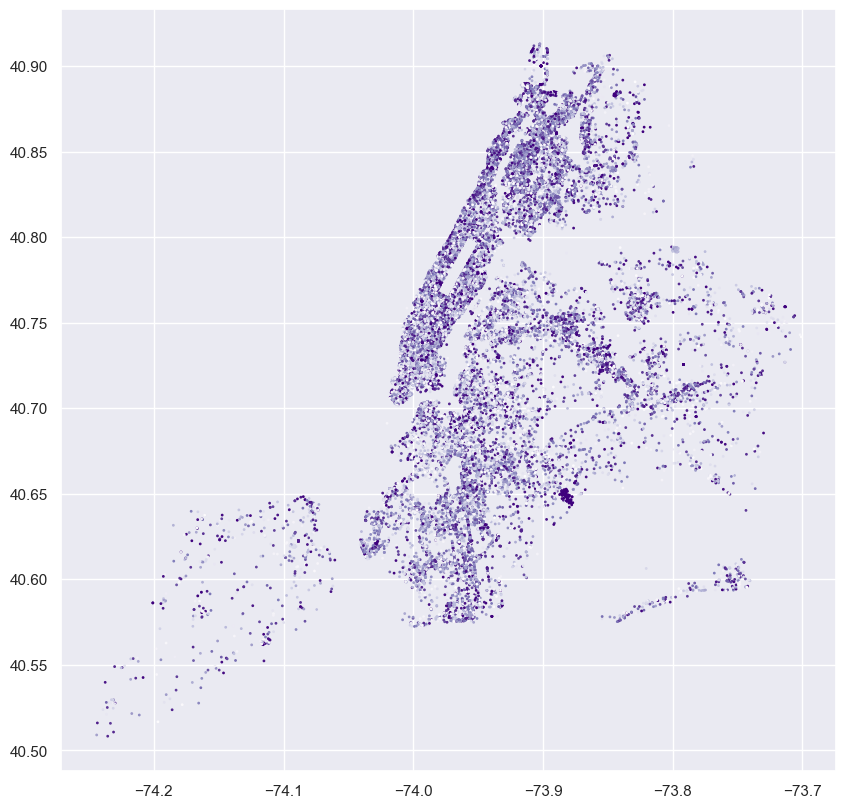

In [91]:
gdfLL842020.plot(column='Site Energy Use (kBtu)',cmap='Purples',figsize=(10,10),markersize=1)

In [92]:
#Switch CRS of Energy data to Censustracts crs
gdfLL842019 = gdfLL842019.to_crs(gpdCensusTracts.crs.to_dict()) 
gdfLL842020 = gdfLL842020.to_crs(gpdCensusTracts.crs.to_dict()) 


c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\pyproj\crs\crs.py:543: UserWarning:

You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems



In [93]:
# fig, ax = plt.subplots(figsize = (20,16)) 
# gpdCensusTracts.geometry.boundary.plot(color='gray',edgecolor='k',linewidth = 0.5,ax=ax)
# gdfLL842020.plot(column='Site Energy Use (kBtu)',cmap='Purples',figsize=(10,10),markersize=8,ax=ax)


In [94]:
gpdCensusTracts=gpdCensusTracts.to_crs(gdfLL842019.crs.to_dict()) 


In [95]:
#Check if Energy Data is valid and drop invalid entries
gdfLL842019=gdfLL842019[gdfLL842019.is_valid]
gdfLL842020=gdfLL842020[gdfLL842020.is_valid]


In [96]:
gdfLL842020['Site Energy Use (kBtu)']

0           28621509.3
1             90318696
2           32329714.8
3           27516842.6
4          126054250.5
             ...      
28062          3088625
28063    Not Available
28064    Not Available
28065          2318409
28066    Not Available
Name: Site Energy Use (kBtu), Length: 27078, dtype: object

In [97]:
# Convert DataFrame column from string to float. Remove entries if not possible
gdfLL842019['Site Energy Use (kBtu)19'] = pd.to_numeric(gdfLL842019['Site Energy Use (kBtu)'], downcast="float",errors='coerce')
gdfLL842019['Site Energy Use (kBtu)19'].dtypes
gdfLL842020['Site Energy Use (kBtu)20'] = pd.to_numeric(gdfLL842020['Site Energy Use (kBtu)'], downcast="float",errors='coerce')
gdfLL842020['Site Energy Use (kBtu)20'].dtypes







dtype('float32')

In [98]:
gdfLL842019['Site Energy Use (kBtu)19']

0        3.434422e+07
1        3.661388e+07
2        3.893956e+07
3        3.921262e+07
4        1.605493e+08
             ...     
29078    8.030824e+05
29079    3.328673e+06
29080    3.533618e+06
29081    7.126884e+05
29082             NaN
Name: Site Energy Use (kBtu)19, Length: 28040, dtype: float32

In [99]:
#Join CensusTracts GEOID with Energy Data
# JoinedData=
EnergyCensus19=pd.DataFrame(gpd.sjoin(gdfLL842019[['geometry','Site Energy Use (kBtu)19']], gpdCensusTracts, how = 'left').groupby(by='GEOID')['Site Energy Use (kBtu)19'].sum())
EnergyCensus20=pd.DataFrame(gpd.sjoin(gdfLL842020[['geometry','Site Energy Use (kBtu)20']], gpdCensusTracts, how = 'left').groupby(by='GEOID')['Site Energy Use (kBtu)20'].sum())

In [100]:
EnergyCensus19['EnergyUse_kWh19']=EnergyCensus19['Site Energy Use (kBtu)19']*0.293014534
EnergyCensus20['EnergyUse_kWh20']=EnergyCensus20['Site Energy Use (kBtu)20']*0.293014534

Part 1: Merge Census Tracts with Population and Energy Data computed by Yanchao

Part 2: Combine median income into CensusTract Data

Part 3: Multivariate Regression. 
First predciting the 2019 energy data then 2020

In [101]:
#Load Census Tracts
CensusTracts=gpd.read_file(r'Data\CensusBldgTypes\Census_BldgTypes.shp')

In [102]:
CensusTracts.shape

(2325, 38)

In [103]:
CensusTracts=CensusTracts.merge(EnergyCensus19,left_on='GEOID',right_on='GEOID')
CensusTracts=CensusTracts.merge(EnergyCensus20,left_on='GEOID',right_on='GEOID')


In [104]:
CensusTracts.shape

(2022, 42)

In [105]:
#load Yanchaos data
PopEnergy=pd.read_csv(r'Data\Yanchaos Energy and Population\totalEngeryAndDayNightPopTractLevel.csv')
#Merge with Censustracts based on BOROCT2020
CensusTracts=CensusTracts.merge(PopEnergy[['BoroCT2020','day19_sum','nt19_sum','day20_sum','nt20_sum']],left_on='BoroCT2020',right_on='BoroCT2020')

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\pandas\core\reshape\merge.py:1208: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation



In [106]:
CensusTracts.columns

Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'Shape_Leng',
       'Shape_Area', 'Temp2022Me', 'EVI2022Mea', 'BldgVolume', 'BldgDensit',
       'Commercial', 'Others', 'Residentia', 'sum', 'income2019', 'income2020',
       'PopCensus1', 'PopCensus2', 'EVI2020Mea', 'Temp20Mean', 'Temp19Mean',
       'EVI19Mean', 'OzoneMean2', 'PM25_2020_', 'NO2_2020Me', 'Traffic202',
       'BldgAge_me', 'st_width_m', 'mAugAirTme', '20June22Te', 'geometry',
       'Site Energy Use (kBtu)19', 'EnergyUse_kWh19',
       'Site Energy Use (kBtu)20', 'EnergyUse_kWh20', 'day19_sum', 'nt19_sum',
       'day20_sum', 'nt20_sum'],
      dtype='object')

In [107]:
CensusTracts.describe()

,BoroCT2020,Shape_Leng,Shape_Area,Temp2022Me,EVI2022Mea,BldgVolume,BldgDensit,Commercial,Others,Residentia,...,mAugAirTme,20June22Te,Site Energy Use (kBtu)19,EnergyUse_kWh19,Site Energy Use (kBtu)20,EnergyUse_kWh20,day19_sum,nt19_sum,day20_sum,nt20_sum
count,1.596000e+03,1596.000000,1.596000e+03,1596.000000,1596.000000,1.596000e+03,1596.000000,1596.000000,1596.000000,1596.000000,...,1596.000000,1596.000000,1.596000e+03,1.596000e+03,1.596000e+03,1.596000e+03,1596.000000,1596.000000,1596.000000,1596.000000
mean,2.992124e+06,8440.266104,3.762502e+06,26.073952,0.123103,3.879796e+06,18.644501,0.137801,0.093681,0.768518,...,299.028714,45.298011,1.726123e+08,5.057792e+07,1.812711e+08,5.311501e+07,4694.023183,3753.867168,4694.023183,3753.867168
std,1.169989e+06,6725.771754,8.006954e+06,2.025478,0.074035,4.772572e+06,24.361776,0.172985,0.118546,0.240896,...,0.178101,2.092272,4.452898e+08,1.304764e+08,1.635457e+09,4.792130e+08,8114.642344,2024.983004,8114.642344,2024.983004
min,1.000201e+06,2569.477865,4.005503e+05,17.897590,-0.021512,1.684633e+04,0.065000,0.000000,0.000000,0.000000,...,298.393311,36.276194,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,52.000000,0.000000,52.000000,0.000000
25%,2.031350e+06,5502.063941,1.614209e+06,24.612525,0.073771,1.744141e+06,7.563000,0.033270,0.028403,0.718501,...,298.933344,44.178361,1.643580e+07,4.815928e+06,1.469746e+07,4.306569e+06,1647.500000,2357.000000,1647.500000,2357.000000
50%,3.046202e+06,6365.945152,1.962091e+06,26.235620,0.106598,2.484498e+06,11.769000,0.069429,0.054770,0.864779,...,299.025024,45.409447,5.348275e+07,1.567122e+07,4.724341e+07,1.384300e+07,2560.000000,3495.000000,2560.000000,3495.000000
75%,4.035800e+06,8821.547845,3.228617e+06,27.621856,0.156722,4.011170e+06,18.658500,0.166667,0.108749,0.925926,...,299.139902,46.667269,1.524442e+08,4.466836e+07,1.370428e+08,4.015552e+07,4337.500000,4841.000000,4337.500000,4841.000000
max,5.032300e+06,103582.252969,1.971899e+08,30.879983,0.564692,5.971268e+07,216.310000,1.000000,1.000000,1.000000,...,299.440002,50.472523,1.072317e+10,3.142045e+09,6.434798e+10,1.885489e+10,91250.000000,15713.000000,91250.000000,15713.000000


<AxesSubplot:>

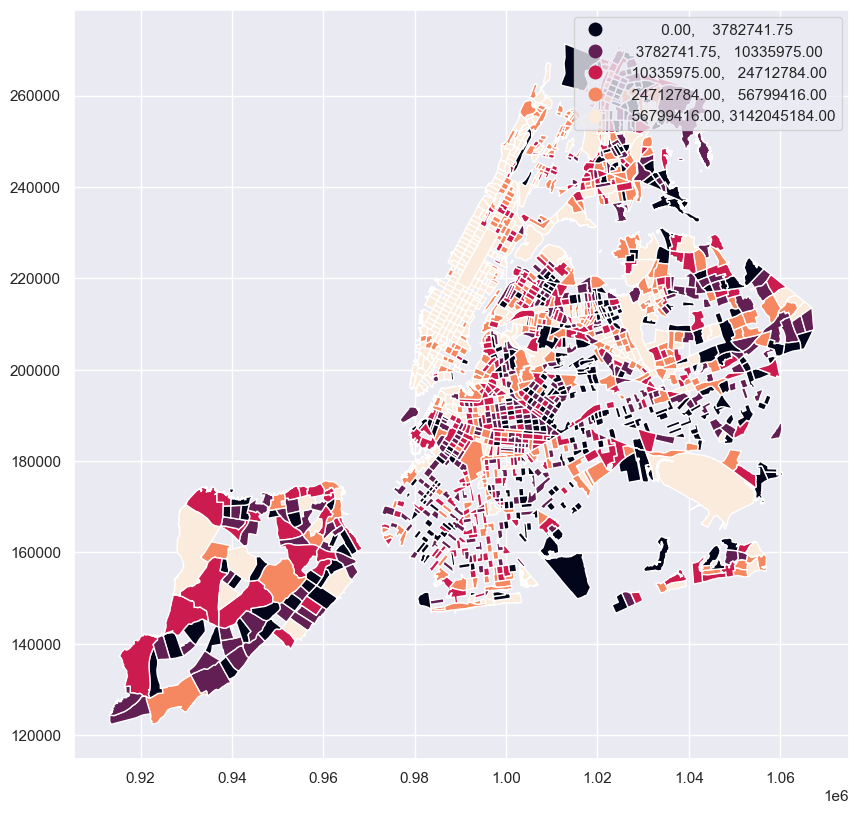

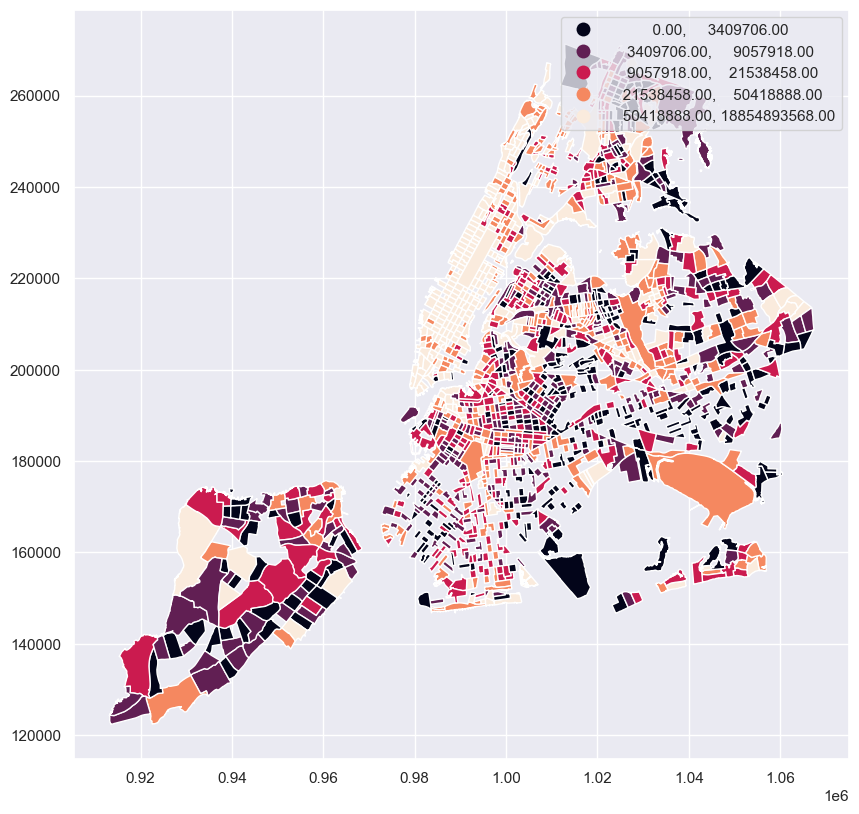

In [108]:
CensusTracts.plot(column='EnergyUse_kWh19',figsize=(10,10),scheme='quantiles',legend=True)
CensusTracts.plot(column='EnergyUse_kWh20',figsize=(10,10),scheme='quantiles',legend=True)


In [109]:
#Pick out columns important for the regression
CensusTracts=CensusTracts[['BldgVolume','BldgDensit','Commercial','Others','Residentia','income2019','income2020','day19_sum','nt19_sum','day20_sum','nt20_sum','Temp19Mean','Temp20Mean','EVI2020Mea','EVI19Mean','PopCensus2','EnergyUse_kWh19','EnergyUse_kWh20']]

In [110]:
#Rename Columns:
CensusTracts = CensusTracts.rename(columns={'BldgDensit': 'BldgDensity', 'Residentia': 'Residential','day19_sum':'PopDay19','nt19_sum':'PopNight19','day20_sum':'PopDay20','nt20_sum':'PopNight20','EVI2020Mea':'EVI20Mean','PopCensus2':'PopCensus20'})

In [111]:
CensusTracts.columns

Index(['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential',
       'income2019', 'income2020', 'PopDay19', 'PopNight19', 'PopDay20',
       'PopNight20', 'Temp19Mean', 'Temp20Mean', 'EVI20Mean', 'EVI19Mean',
       'PopCensus20', 'EnergyUse_kWh19', 'EnergyUse_kWh20'],
      dtype='object')

In [112]:
#1815 after merge with Energy data. Some census tracts dont have energy data.
CensusTracts.shape

(1596, 18)

In [113]:
#Some Census Data is coprruped for the total Pop per tract. In reality there is no census tract where noone lives. 
CensusTracts.loc[CensusTracts.PopCensus20==0]

#We could increase the Pop in these Tracts by 1. 
# CensusTracts['Pop2020Mod']=CensusTracts['PopCensu_1']+1

,BldgVolume,BldgDensity,Commercial,Others,Residential,income2019,income2020,PopDay19,PopNight19,PopDay20,PopNight20,Temp19Mean,Temp20Mean,EVI20Mean,EVI19Mean,PopCensus20,EnergyUse_kWh19,EnergyUse_kWh20
177,1.973621e+06,7.563,0.545455,0.454545,0.000000,NaN,NaN,2973.0,288.0,2973.0,288.0,22.621528,24.526168,0.160304,0.302195,0.0,2.936737e+06,2.025084e+06
333,1.910935e+05,1.005,0.500000,0.500000,0.000000,NaN,NaN,1289.0,168.0,1289.0,168.0,19.960860,20.298110,0.233045,0.570735,0.0,2.679973e+06,2.295368e+06
334,5.496599e+05,0.075,0.076923,0.500000,0.423077,NaN,NaN,440.0,13.0,440.0,13.0,17.734451,17.811589,0.238679,0.530278,0.0,4.856132e+06,4.174348e+06
343,1.127080e+07,18.970,0.880000,0.120000,0.000000,NaN,NaN,4375.0,201.0,4375.0,201.0,23.804580,24.046608,0.037507,0.070578,0.0,1.325763e+08,1.237350e+08
362,2.241717e+06,7.286,0.103093,0.896907,0.000000,NaN,NaN,1059.0,444.0,1059.0,444.0,22.646302,23.440296,0.020456,0.046170,0.0,3.540930e+06,2.572256e+06
657,5.350333e+06,10.854,0.942857,0.057143,0.000000,NaN,NaN,3314.0,0.0,3314.0,0.0,20.900932,22.529520,0.022351,0.059375,0.0,3.625857e+08,1.739901e+08
739,3.288849e+06,7.741,0.796875,0.203125,0.000000,NaN,NaN,2342.0,49.0,2342.0,49.0,24.154976,24.726256,0.047876,0.139527,0.0,6.743655e+06,9.837924e+06
751,6.389435e+05,2.910,0.666667,0.333333,0.000000,NaN,NaN,425.0,0.0,425.0,0.0,21.867907,23.125058,0.119736,0.242775,0.0,4.925617e+07,5.120134e+07
769,8.095037e+05,1.076,0.150000,0.800000,0.050000,NaN,NaN,2640.0,245.0,2640.0,245.0,19.995221,22.525445,0.378721,0.594927,0.0,1.432541e+07,1.061155e+07
798,6.015293e+05,1.718,0.142857,0.250000,0.607143,NaN,NaN,1384.0,59.0,1384.0,59.0,10.881039,20.109532,0.261877,0.508641,0.0,2.125197e+07,8.092608e+06


In [114]:
#drop rows with NaN to be able to run regressions 
CensusTracts=CensusTracts.dropna()

In [115]:
#1214 Census tracts remain after rows with no values get dropped
CensusTracts.shape

(1328, 18)

In [116]:
CensusTracts

,BldgVolume,BldgDensity,Commercial,Others,Residential,income2019,income2020,PopDay19,PopNight19,PopDay20,PopNight20,Temp19Mean,Temp20Mean,EVI20Mean,EVI19Mean,PopCensus20,EnergyUse_kWh19,EnergyUse_kWh20
0,1.936552e+06,21.438,0.170732,0.121951,0.707317,29500.0,30435.0,2433.0,2610.0,2433.0,2610.0,22.344132,23.119423,0.060165,0.154512,2761.0,2936519.0,2289739.5
1,7.281368e+06,30.346,0.128049,0.207317,0.664634,16600.0,17398.0,5940.0,9512.0,5940.0,9512.0,21.143078,21.827769,0.048636,0.148966,10628.0,131081536.0,85416384.0
2,1.876775e+06,20.078,0.181818,0.454545,0.363636,103750.0,97875.0,2194.0,3220.0,2194.0,3220.0,22.030582,22.692742,0.073643,0.246064,2999.0,45118044.0,74805920.0
3,7.376846e+06,33.095,0.274194,0.119355,0.606452,50568.0,51480.0,9595.0,5822.0,9595.0,5822.0,22.554433,22.650927,0.021474,0.111043,7101.0,66089008.0,43620188.0
4,2.722903e+07,114.485,0.308571,0.400000,0.291429,250001.0,250001.0,35794.0,5988.0,35794.0,5988.0,21.639162,21.451571,0.005039,0.062358,6868.0,333405152.0,243436336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,2.445850e+06,13.108,0.048583,0.052632,0.898785,71767.0,77191.0,799.0,2223.0,799.0,2223.0,21.453523,23.894251,0.085928,0.193322,2168.0,8795739.0,8601279.0
1589,5.388328e+06,29.536,0.307692,0.092308,0.600000,89868.0,94345.0,4605.0,7535.0,4605.0,7535.0,20.932021,22.562904,0.048246,0.157040,7576.0,105953296.0,88827320.0
1591,2.902529e+06,16.118,0.224265,0.040441,0.735294,88971.0,77667.0,1884.0,4193.0,1884.0,4193.0,22.609315,22.730232,0.072125,0.256734,4081.0,53044456.0,44023848.0
1592,1.181982e+06,11.589,0.122222,0.022222,0.855556,65000.0,80250.0,1840.0,1123.0,1840.0,1123.0,23.764742,23.805078,0.075270,0.207510,1158.0,22958944.0,17181810.0


In [117]:
#Remove Outlier for 2020. 
CensusTracts=CensusTracts.loc[CensusTracts['EnergyUse_kWh20']!=CensusTracts['EnergyUse_kWh20'].max()]
#Remove Outlier for 2019. 
CensusTracts=CensusTracts.loc[CensusTracts['EnergyUse_kWh19']!=CensusTracts['EnergyUse_kWh19'].max()]


In [118]:
#Normalize Data. All Columns are normalized, but not Energy Data for 2020 and 2019
from sklearn import preprocessing

X = CensusTracts.drop(columns = ['EnergyUse_kWh19','EnergyUse_kWh20']).copy()
y = CensusTracts[['EnergyUse_kWh19','EnergyUse_kWh20']]


#Standard Scaler
scale=preprocessing.StandardScaler()
X_scaled=scale.fit_transform(X)
scaled_CensusTracts=pd.DataFrame(X_scaled)
scaled_CensusTracts.columns=['BldgVolume','BldgDensity','Commercial','Others','Residential','income2019','income2020','PopDay19','PopNight19','PopDay20','PopNight20','Temp19Mean','Temp20Mean','EVI20Mean','EVI19Mean','PopCensus20']
scaled_CensusTracts=scaled_CensusTracts.reset_index().drop(columns='index')
y=y.reset_index().drop(columns='index')
scaled_CensusTracts=scaled_CensusTracts.join(y)
scaled_CensusTracts

,BldgVolume,BldgDensity,Commercial,Others,Residential,income2019,income2020,PopDay19,PopNight19,PopDay20,PopNight20,Temp19Mean,Temp20Mean,EVI20Mean,EVI19Mean,PopCensus20,EnergyUse_kWh19,EnergyUse_kWh20
0,-0.416696,0.098404,0.370135,0.472873,-0.493025,-1.174760,-1.201087,-0.286311,-0.685305,-0.286311,-0.685305,0.007660,-0.290423,-0.178839,-0.413140,-0.638111,2936519.0,2289739.5
1,0.733276,0.456298,0.070976,1.423735,-0.713927,-1.521473,-1.541477,0.123232,2.789525,0.123232,2.789525,-0.726343,-1.249596,-0.421089,-0.478878,3.240709,131081536.0,85416384.0
2,-0.429557,0.043764,0.447839,4.177530,-2.271719,0.820854,0.559744,-0.314221,-0.378198,-0.314221,-0.378198,-0.183961,-0.607273,0.104384,0.672086,-0.520765,45118044.0,74805920.0
3,0.753819,0.566744,1.095286,0.443953,-1.015047,-0.608516,-0.651610,0.550059,0.931785,0.550059,0.931785,0.136181,-0.638325,-0.991848,-0.928398,1.501723,66089008.0,43620188.0
4,5.025147,3.836726,1.336236,3.569966,-2.645425,4.751636,4.531693,3.609547,1.015358,3.609547,1.015358,-0.423170,-1.528959,-1.337183,-1.505496,1.386843,333405152.0,243436336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,-0.307117,-0.236268,-0.485990,-0.299256,0.497905,-0.038752,0.019694,-0.477128,-0.880141,-0.477128,-0.880141,-0.536620,0.284959,0.362526,0.046905,-0.930490,8795739.0,8601279.0
1322,0.325976,0.423755,1.330075,0.142683,-1.048437,0.447748,0.467578,-0.032668,1.794200,-0.032668,1.794200,-0.855327,-0.703690,-0.429274,-0.383165,1.735922,105953296.0,88827320.0
1323,-0.208860,-0.115336,0.745341,-0.435041,-0.348232,0.423640,0.032122,-0.350423,0.111661,-0.350423,0.111661,0.169721,-0.579433,0.072473,0.798562,0.012714,53044456.0,44023848.0
1324,-0.579047,-0.297296,0.030138,-0.637975,0.274172,-0.220628,0.099563,-0.355561,-1.433939,-0.355561,-1.433939,0.875840,0.218740,0.138570,0.215080,-1.428470,22958944.0,17181810.0


In [119]:
#Create Dataframes with 2019 Regressors and 2019 Energy Data
scaled_CensusTracts2019=scaled_CensusTracts[['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential',
       'income2019','PopDay19', 'PopNight19','Temp19Mean', 'EnergyUse_kWh19']]

scaled_CensusTracts2020=scaled_CensusTracts[['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential',
       'income2020','PopDay20', 'PopNight20','Temp20Mean', 'EnergyUse_kWh20']]
#NonStandardized
CensusTracts2019=CensusTracts[['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential',
       'income2019','PopDay19', 'PopNight19','Temp19Mean', 'EnergyUse_kWh19']]
CensusTracts2020=CensusTracts[['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential',
       'income2020','PopDay20', 'PopNight20','Temp20Mean', 'EnergyUse_kWh20']]

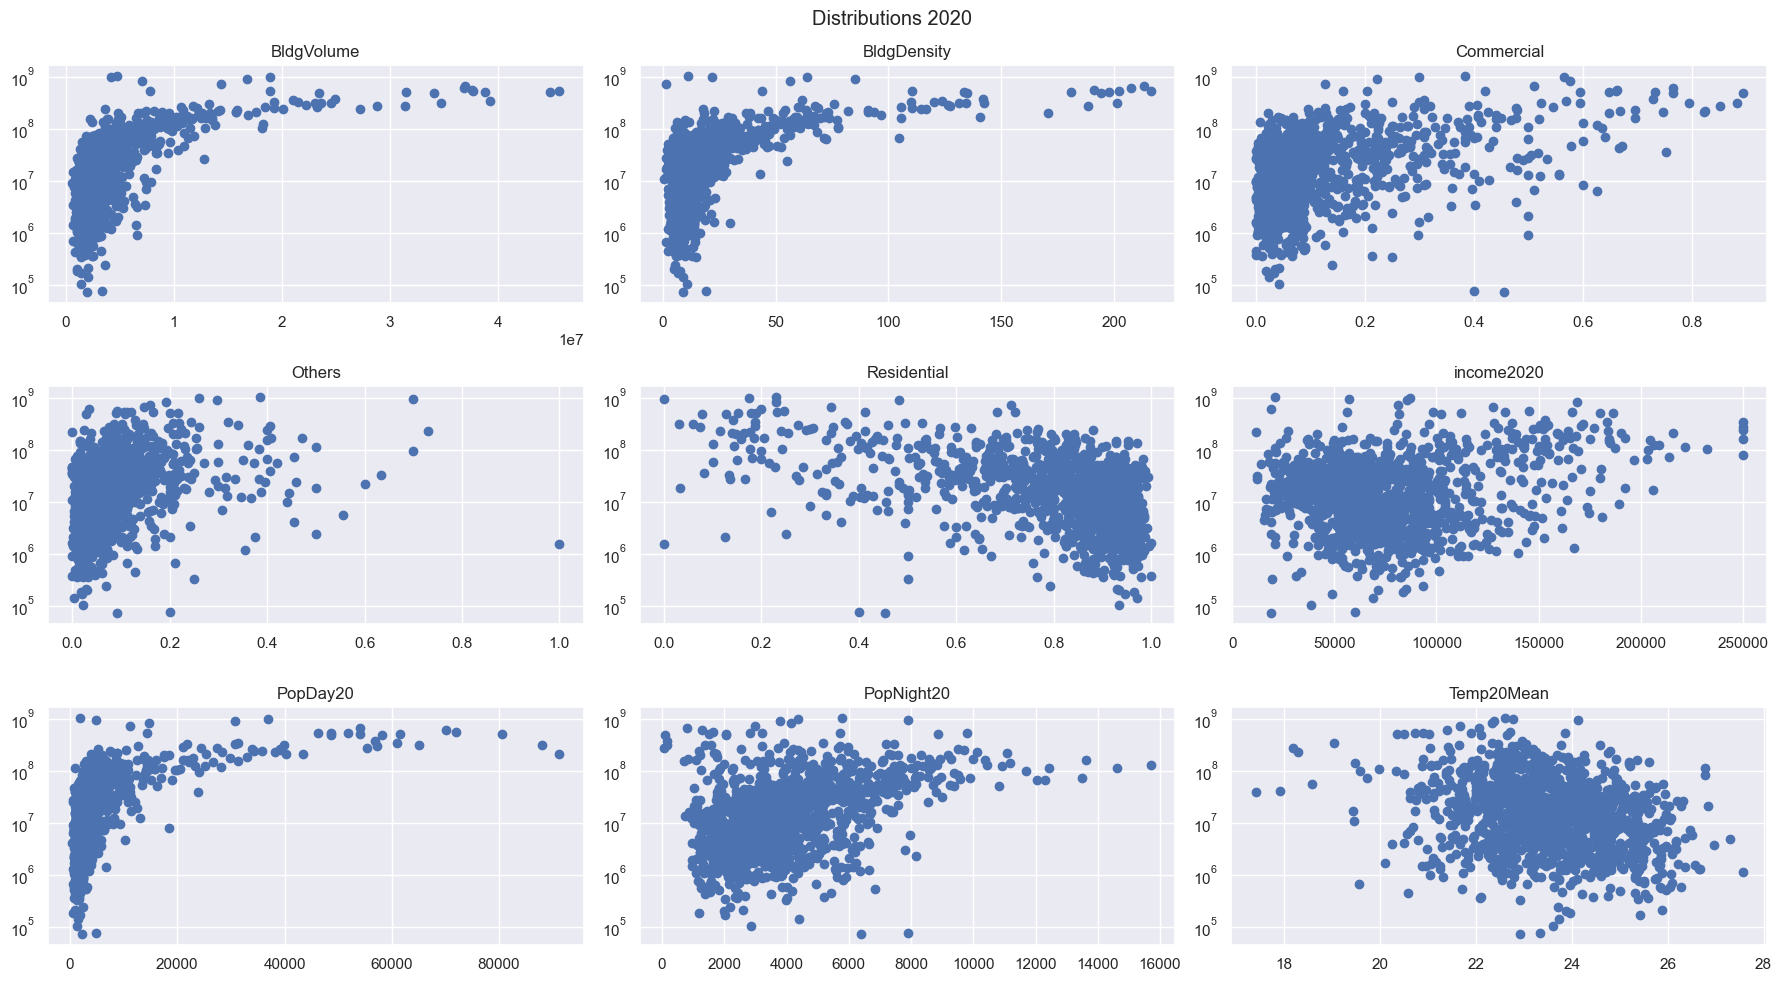

In [120]:
#Sanity Check of Input Data
#CensusTracts2020

sns.set()
fig, ax = plt.subplots(3, 3,figsize=(18, 10))
 
fig.suptitle('Distributions 2020')


ax[0,0].scatter(x=CensusTracts2020['BldgVolume'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[0,1].scatter(x=CensusTracts2020['BldgDensity'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[0,2].scatter(x=CensusTracts2020['Commercial'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[1,0].scatter(x=CensusTracts2020['Others'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[1,1].scatter(x=CensusTracts2020['Residential'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[1,2].scatter(x=CensusTracts2020['income2020'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[2,0].scatter(x=CensusTracts2020['PopDay20'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[2,1].scatter(x=CensusTracts2020['PopNight20'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[2,2].scatter(x=CensusTracts2020['Temp20Mean'],y=CensusTracts2020['EnergyUse_kWh20'])
ax[0,0].set_title("BldgVolume")
ax[0,1].set_title("BldgDensity")
ax[0,2].set_title("Commercial")
ax[1,0].set_title("Others")
ax[1,1].set_title("Residential")
ax[1,2].set_title("income2020")
ax[2,0].set_title("PopDay20")
ax[2,1].set_title("PopNight20")
ax[2,2].set_title("Temp20Mean")
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[0,2].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_yscale('log')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')
ax[2,2].set_yscale('log')


# ax.set_scale('log')

plt.tight_layout()
plt.show()

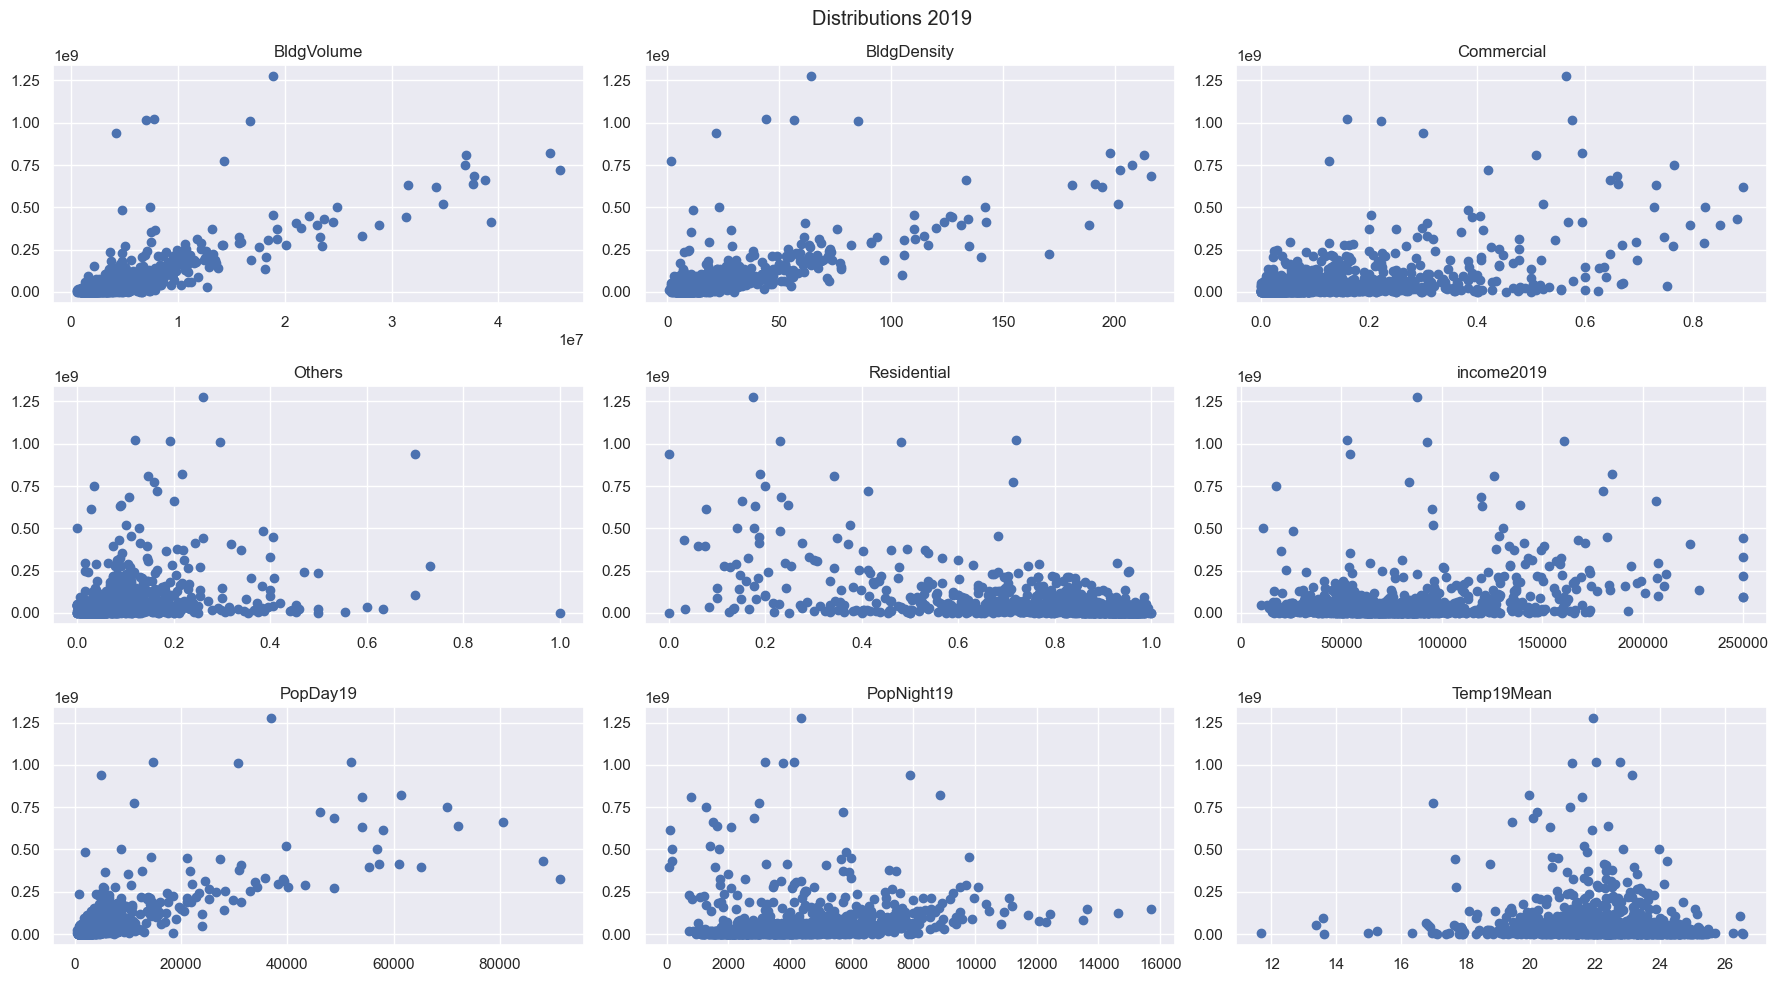

In [121]:
#Sanity Check of Input Data
# scaled_CensusTracts2019

sns.set()
fig, ax = plt.subplots(3, 3,figsize=(18, 10))
 
fig.suptitle('Distributions 2019')


ax[0,0].scatter(x=CensusTracts2019['BldgVolume'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[0,1].scatter(x=CensusTracts2019['BldgDensity'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[0,2].scatter(x=CensusTracts2019['Commercial'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[1,0].scatter(x=CensusTracts2019['Others'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[1,1].scatter(x=CensusTracts2019['Residential'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[1,2].scatter(x=CensusTracts2019['income2019'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[2,0].scatter(x=CensusTracts2019['PopDay19'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[2,1].scatter(x=CensusTracts2019['PopNight19'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[2,2].scatter(x=CensusTracts2019['Temp19Mean'],y=CensusTracts2019['EnergyUse_kWh19'])
ax[0,0].set_title("BldgVolume")
ax[0,1].set_title("BldgDensity")
ax[0,2].set_title("Commercial")
ax[1,0].set_title("Others")
ax[1,1].set_title("Residential")
ax[1,2].set_title("income2019")
ax[2,0].set_title("PopDay19")
ax[2,1].set_title("PopNight19")
ax[2,2].set_title("Temp19Mean")





plt.tight_layout()
plt.show()


In [122]:
# Correlation Matrix After Standardization 2019

# Fill diagonal and upper half with NaNs
corr = CensusTracts2019.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,BldgVolume,BldgDensity,Commercial,Others,Residential,income2019,PopDay19,PopNight19,Temp19Mean,EnergyUse_kWh19
BldgVolume,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BldgDensity,0.88,nan,nan,nan,nan,nan,nan,nan,nan,nan
Commercial,0.57,0.60,nan,nan,nan,nan,nan,nan,nan,nan
Others,0.27,0.26,0.35,nan,nan,nan,nan,nan,nan,nan
Residential,-0.55,-0.57,-0.90,-0.72,nan,nan,nan,nan,nan,nan
income2019,0.47,0.44,0.14,0.09,-0.14,nan,nan,nan,nan,nan
PopDay19,0.87,0.81,0.62,0.18,-0.54,0.38,nan,nan,nan,nan
PopNight19,0.20,0.12,-0.05,0.15,-0.03,0.01,0.05,nan,nan,nan
Temp19Mean,-0.15,-0.13,0.02,-0.18,0.07,-0.16,-0.05,-0.17,nan,nan
EnergyUse_kWh19,0.78,0.75,0.53,0.31,-0.54,0.32,0.75,0.17,-0.13,nan


In [123]:
# Correlation Matrix After Standardization 2020

# Fill diagonal and upper half with NaNs
corr = CensusTracts2020.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,BldgVolume,BldgDensity,Commercial,Others,Residential,income2020,PopDay20,PopNight20,Temp20Mean,EnergyUse_kWh20
BldgVolume,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BldgDensity,0.88,nan,nan,nan,nan,nan,nan,nan,nan,nan
Commercial,0.57,0.60,nan,nan,nan,nan,nan,nan,nan,nan
Others,0.27,0.26,0.35,nan,nan,nan,nan,nan,nan,nan
Residential,-0.55,-0.57,-0.90,-0.72,nan,nan,nan,nan,nan,nan
income2020,0.44,0.42,0.12,0.09,-0.13,nan,nan,nan,nan,nan
PopDay20,0.87,0.81,0.62,0.18,-0.54,0.35,nan,nan,nan,nan
PopNight20,0.20,0.12,-0.05,0.15,-0.03,0.01,0.05,nan,nan,nan
Temp20Mean,-0.25,-0.32,-0.08,-0.17,0.14,-0.25,-0.16,-0.24,nan,nan
EnergyUse_kWh20,0.74,0.71,0.50,0.32,-0.52,0.27,0.68,0.20,-0.23,nan


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='BldgVolume', ylabel='EnergyUse_kWh20'>

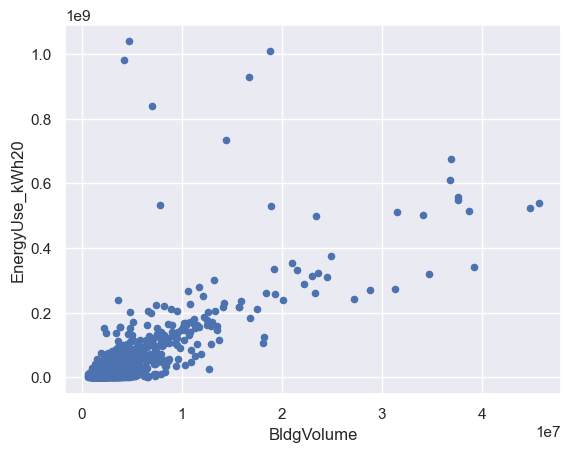

In [124]:
CensusTracts.plot.scatter(x='BldgVolume',y='EnergyUse_kWh20')

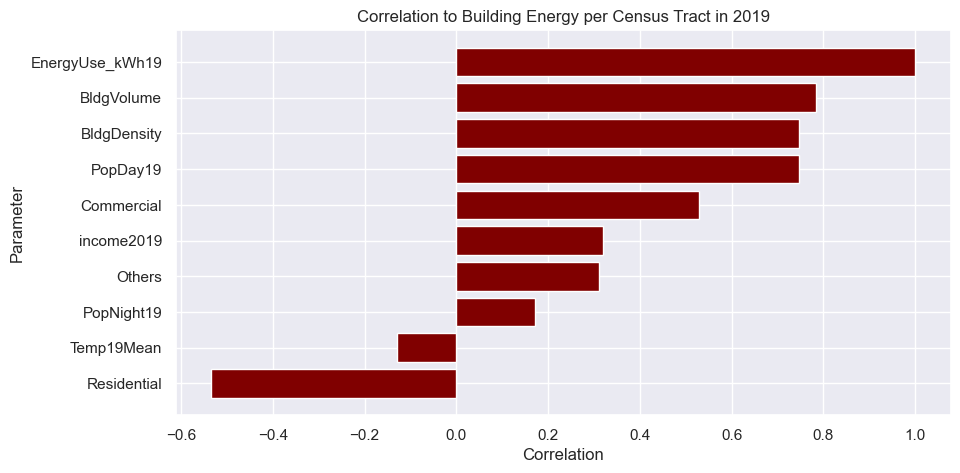

In [125]:
#Correlation of 2019 data to toteng19

Correlations19=pd.DataFrame(scaled_CensusTracts2019.corr()['EnergyUse_kWh19']).sort_values(by='EnergyUse_kWh19',ascending=True)

fig = plt.figure(figsize=(10, 5))
# creating the bar plot
plt.barh(Correlations19.index, Correlations19['EnergyUse_kWh19'], color='maroon')
plt.xlabel("Correlation")
plt.ylabel("Parameter")
plt.title("Correlation to Building Energy per Census Tract in 2019")
plt.show()


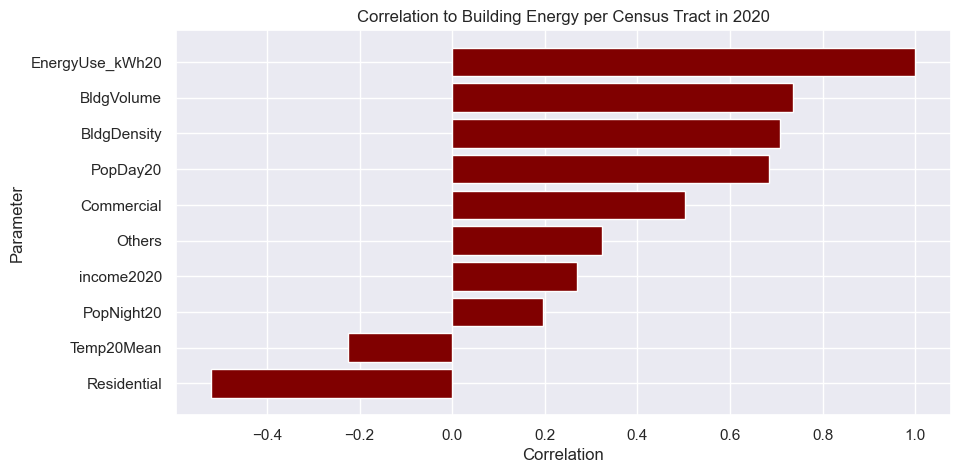

In [126]:
#Correlation of 2020 data to toteng20

Correlations20=pd.DataFrame(scaled_CensusTracts2020.corr()['EnergyUse_kWh20']).sort_values(by='EnergyUse_kWh20',ascending=True)

fig = plt.figure(figsize=(10, 5))
# creating the bar plot
plt.barh(Correlations20.index, Correlations20['EnergyUse_kWh20'], color='maroon')
plt.xlabel("Correlation")
plt.ylabel("Parameter")
plt.title("Correlation to Building Energy per Census Tract in 2020")
plt.show()

In [127]:
#Regression for the requested Columns
lm2019 = smf.ols(formula = 'EnergyUse_kWh19 ~ BldgVolume + BldgDensity + Commercial +Others+ Residential + income2019+ PopDay19 + PopNight19+  Temp19Mean -1', data = scaled_CensusTracts2019).fit()
print(lm2019.summary())


                                 OLS Regression Results                                
Dep. Variable:        EnergyUse_kWh19   R-squared (uncentered):                   0.545
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              197.7
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                   1.84e-219
Time:                        11:56:56   Log-Likelihood:                         -26038.
No. Observations:                1326   AIC:                                  5.209e+04
Df Residuals:                    1318   BIC:                                  5.213e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [128]:
lm2020 = smf.ols(formula = 'EnergyUse_kWh20 ~ BldgVolume + BldgDensity + Commercial +Others+ Residential + income2020+ PopDay20 + PopNight20 +  Temp20Mean -1', data = CensusTracts).fit()
print(lm2020.summary())



                            OLS Regression Results                            
Dep. Variable:        EnergyUse_kWh20   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     234.6
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          4.75e-247
Time:                        11:56:57   Log-Likelihood:                -25628.
No. Observations:                1326   AIC:                         5.127e+04
Df Residuals:                    1317   BIC:                         5.132e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
BldgVolume      6.7733      0.969      6.993      

In [129]:
lm2020.params.sort_values(ascending=False)

Others         1.239109e+08
Commercial     2.162701e+07
BldgDensity    8.006264e+05
PopNight20     3.346223e+03
PopDay20       2.056486e+03
BldgVolume     6.773271e+00
income2020    -1.277886e+02
Residential   -4.633623e+05
Temp20Mean    -1.037413e+06
dtype: float64

In [130]:
#which feature is important, which one incrases R2 

In [131]:
lm2019.params.sort_values(ascending=False)

BldgVolume     3.930948e+07
PopDay19       2.878303e+07
BldgDensity    2.130192e+07
Others         9.078408e+06
PopNight19     5.090015e+06
Commercial    -2.616196e+05
Temp19Mean    -1.908844e+06
Residential   -4.024971e+06
income2019    -5.122380e+06
dtype: float64

In [132]:
scaled_CensusTracts2019

,BldgVolume,BldgDensity,Commercial,Others,Residential,income2019,PopDay19,PopNight19,Temp19Mean,EnergyUse_kWh19
0,-0.416696,0.098404,0.370135,0.472873,-0.493025,-1.174760,-0.286311,-0.685305,0.007660,2936519.0
1,0.733276,0.456298,0.070976,1.423735,-0.713927,-1.521473,0.123232,2.789525,-0.726343,131081536.0
2,-0.429557,0.043764,0.447839,4.177530,-2.271719,0.820854,-0.314221,-0.378198,-0.183961,45118044.0
3,0.753819,0.566744,1.095286,0.443953,-1.015047,-0.608516,0.550059,0.931785,0.136181,66089008.0
4,5.025147,3.836726,1.336236,3.569966,-2.645425,4.751636,3.609547,1.015358,-0.423170,333405152.0
...,...,...,...,...,...,...,...,...,...,...
1321,-0.307117,-0.236268,-0.485990,-0.299256,0.497905,-0.038752,-0.477128,-0.880141,-0.536620,8795739.0
1322,0.325976,0.423755,1.330075,0.142683,-1.048437,0.447748,-0.032668,1.794200,-0.855327,105953296.0
1323,-0.208860,-0.115336,0.745341,-0.435041,-0.348232,0.423640,-0.350423,0.111661,0.169721,53044456.0
1324,-0.579047,-0.297296,0.030138,-0.637975,0.274172,-0.220628,-0.355561,-1.433939,0.875840,22958944.0


In [133]:
#DOMINANCE Analysis
# from dominance_analysis import Dominance_Datasets
from dominance_analysis import Dominance

dominance_regression19=Dominance(data=scaled_CensusTracts2019.copy(),target='EnergyUse_kWh19',objective=1)
dominance_regression20=Dominance(data=scaled_CensusTracts2020.copy(),target='EnergyUse_kWh20',objective=1)

Selecting 9 Best Predictors for the Model
Selected Predictors :  ['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential', 'income2019', 'PopDay19', 'PopNight19', 'Temp19Mean']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.6584888328974152

Selecting 9 Best Predictors for the Model
Selected Predictors :  ['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential', 'income2020', 'PopDay20', 'PopNight20', 'Temp20Mean']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.5876109272650891



In [134]:
dominance_regression19.incremental_rsquare()

# from dominance_analysis import Dominance
# dominance_regression = Dominance(data=X_train, target='TARGET', objective=1)
# dominance_regression.incremental_rsquare()

Selecting 9 Best Predictors for the Model
Selected Predictors :  ['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential', 'income2019', 'PopDay19', 'PopNight19', 'Temp19Mean']

Creating models for 511 possible combinations of 9 features :


100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 8/8 [00:00<00:00, 85.39it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################



{'BldgVolume': 0.18217551483754993,
 'BldgDensity': 0.1496245997149119,
 'Commercial': 0.05525337548115591,
 'Others': 0.020230895755785277,
 'Residential': 0.05790305967671583,
 'income2019': 0.022383400863945413,
 'PopDay19': 0.15689468629126846,
 'PopNight19': 0.010225967121557808,
 'Temp19Mean': 0.003797333154524744}

In [178]:
dominance_regression19.plot_incremental_rsquare()

In [136]:
dominance_regression19.dominance_stats()

,Interactional Dominance,Individual Dominance,Average Partial Dominance,Total Dominance,Percentage Relative Importance
BldgVolume,0.017035,0.615235,0.143901,0.182176,27.665695
PopDay19,0.014209,0.556152,0.120242,0.156895,23.826476
BldgDensity,0.007441,0.558851,0.111476,0.149625,22.72242
Residential,0.000438,0.286485,0.033458,0.057903,8.793324
Commercial,0.000438,0.280467,0.030911,0.055253,8.390936
income2019,0.001588,0.102266,0.013942,0.022383,3.399207
Others,0.000438,0.096301,0.012191,0.020231,3.072322
PopNight19,0.001725,0.029394,0.008702,0.010226,1.552945
Temp19Mean,0.000287,0.016455,0.002491,0.003797,0.576674


In [137]:
dominance_regression19.dominance_level()

,Predictors,Generally Dominating,Conditionally Dominating,Completely Dominating
0,BldgVolume,"[PopDay19, BldgDensity, Residential, Commercia...","[PopDay19, BldgDensity, Residential, Commercia...","[PopDay19, BldgDensity, Residential, Commercia..."
1,PopDay19,"[BldgDensity, Residential, Commercial, income2...",,
2,BldgDensity,"[Residential, Commercial, income2019, Others, ...","[Residential, Commercial, income2019, Others, ...","[Residential, Commercial, income2019, Others, ..."
3,Residential,"[Commercial, income2019, Others, PopNight19, T...",,
4,Commercial,"[income2019, Others, PopNight19, Temp19Mean]",,
5,income2019,"[Others, PopNight19, Temp19Mean]",,
6,Others,"[PopNight19, Temp19Mean]",,
7,PopNight19,[Temp19Mean],[Temp19Mean],[Temp19Mean]
8,Temp19Mean,[],,


In [138]:
dominance_regression20.incremental_rsquare()

Selecting 9 Best Predictors for the Model
Selected Predictors :  ['BldgVolume', 'BldgDensity', 'Commercial', 'Others', 'Residential', 'income2020', 'PopDay20', 'PopNight20', 'Temp20Mean']

Creating models for 511 possible combinations of 9 features :


100%|██████████| 9/9 [00:01<00:00,  5.09it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 8/8 [00:00<00:00, 80.38it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################



{'BldgVolume': 0.15870215936345314,
 'BldgDensity': 0.13469521552214742,
 'Commercial': 0.04979482444261117,
 'Others': 0.023038797969898037,
 'Residential': 0.0559582249689181,
 'income2020': 0.015666453427009112,
 'PopDay20': 0.12532401478033012,
 'PopNight20': 0.014462903801650476,
 'Temp20Mean': 0.009968332989071542}

In [177]:
dominance_regression20.plot_incremental_rsquare()

In [140]:
dominance_regression19.dominance_stats()

,Interactional Dominance,Individual Dominance,Average Partial Dominance,Total Dominance,Percentage Relative Importance
BldgVolume,0.017035,0.615235,0.143901,0.182176,27.665695
PopDay19,0.014209,0.556152,0.120242,0.156895,23.826476
BldgDensity,0.007441,0.558851,0.111476,0.149625,22.72242
Residential,0.000438,0.286485,0.033458,0.057903,8.793324
Commercial,0.000438,0.280467,0.030911,0.055253,8.390936
income2019,0.001588,0.102266,0.013942,0.022383,3.399207
Others,0.000438,0.096301,0.012191,0.020231,3.072322
PopNight19,0.001725,0.029394,0.008702,0.010226,1.552945
Temp19Mean,0.000287,0.016455,0.002491,0.003797,0.576674


In [141]:
dominance_regression19.dominance_level()

,Predictors,Generally Dominating,Conditionally Dominating,Completely Dominating
0,BldgVolume,"[PopDay19, BldgDensity, Residential, Commercia...","[PopDay19, BldgDensity, Residential, Commercia...","[PopDay19, BldgDensity, Residential, Commercia..."
1,PopDay19,"[BldgDensity, Residential, Commercial, income2...",,
2,BldgDensity,"[Residential, Commercial, income2019, Others, ...","[Residential, Commercial, income2019, Others, ...","[Residential, Commercial, income2019, Others, ..."
3,Residential,"[Commercial, income2019, Others, PopNight19, T...",,
4,Commercial,"[income2019, Others, PopNight19, Temp19Mean]",,
5,income2019,"[Others, PopNight19, Temp19Mean]",,
6,Others,"[PopNight19, Temp19Mean]",,
7,PopNight19,[Temp19Mean],[Temp19Mean],[Temp19Mean]
8,Temp19Mean,[],,


In [142]:
#GROUP COMPONENTS TOGETHER


In [143]:
# # pca analysis

# X19 = scaled_CensusTracts2019.drop(columns = ['totEng19']).copy()
# y19 = scaled_CensusTracts2019['totEng19']
# #scale predictor variables
# pca = PCA()
# X19_reduced = pca.fit_transform(X19)
# #define cross validation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# regr = LinearRegression()
# mse = []
# # Calculate MSE with only the intercept
# score = -1*model_selection.cross_val_score(regr,
#            np.ones((len(X19_reduced),1)), y19, cv=cv,
#            scoring='neg_mean_squared_error').mean()    
# mse.append(score)
# # Calculate MSE using cross-validation, adding one component at a time
# for i in np.arange(1, 15):
#     score = -1*model_selection.cross_val_score(regr,
#                X19_reduced[:,:i], y19, cv=cv, scoring='neg_mean_squared_error').mean()
#     mse.append(score)
    
# # Plot cross-validation results    
# plt.plot(mse)
# plt.xlabel('Number of Principal Components')
# plt.ylabel('MSE')
# plt.title('TotEng19')




In [144]:
# pca = PCA(n_components=1)
# X19_reduced = pca.fit_transform(X19)

# principal_X19_reduced_Df =pd.DataFrame(data = X19_reduced,columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5', 'principal component 6','principal component 7', 'principal component 8', 'principal component 9'])



In [145]:
# principal_X19_reduced_Df

In [146]:
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [147]:
#Explained Data with all PCAs: Meaning: with 9 PC's we have represented all the information from the CensusTract data 
# np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [148]:
# #split the dataset into training (80%) and testing (30%) sets
# X19_train,X19_test,y19_train,y19_test = train_test_split(X19,y19,test_size=0.8,random_state=0) 

# #scale the training and testing data
# X_reduced_train = pca.fit_transform(X19_train)

# #train PCR model on training data 
# regr = LinearRegression()
# regr.fit(X_reduced_train, y19_train)

# YPred_IS = regr.predict(X_reduced_train)

# print(regr.coef_)
# r2_score(y19_train,YPred_IS)


In [149]:
#then regreseion

In [150]:
#

In [151]:
# scaled_CensusTracts2019.columns

In [152]:
#Better Regression methods
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset

#Prepare datasets for 2019

X19 = scaled_CensusTracts2019.drop(columns = ['EnergyUse_kWh19']).copy()
y19 = scaled_CensusTracts2019['EnergyUse_kWh19']
# In the first step we will split the data in training and remaining dataset
X19_train, X19_rem, y19_train, y19_rem = train_test_split(X19,y19, train_size=0.8)
# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X19_valid, X19_test, y19_valid, y19_test = train_test_split(X19_rem,y19_rem, test_size=0.5)

print(X19_train.shape), print(y19_train.shape)
print(X19_valid.shape), print(y19_valid.shape)
print(X19_test.shape), print(y19_test.shape)


#Prepare datasets for 2020

X20 = scaled_CensusTracts2020.drop(columns = ['EnergyUse_kWh20']).copy()
y20 = scaled_CensusTracts2020['EnergyUse_kWh20']
# In the first step we will split the data in training and remaining dataset
X20_train, X20_rem, y20_train, y20_rem = train_test_split(X20,y20, train_size=0.8)
# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X20_valid, X20_test, y20_valid, y20_test = train_test_split(X20_rem,y20_rem, test_size=0.5)

print(X20_train.shape), print(y20_train.shape)
print(X20_valid.shape), print(y20_valid.shape)
print(X20_test.shape), print(y20_test.shape)


(1060, 9)
(1060,)
(133, 9)
(133,)
(133, 9)
(133,)
(1060, 9)
(1060,)
(133, 9)
(133,)
(133, 9)
(133,)


(None, None)

In [153]:
# #try Lasso for 2019 
# # with an another arbitrary regularization parameter alpha=0.01 (not enough regularization yet)
# Lasso19=linear_model.Lasso(fit_intercept=False, alpha=0.1)

# Lasso19.fit(X19_train,y19_train)
# # In sample:
# YPred_IS_Lasso19=Lasso19.predict(X19_train)
# print("The IS R-squared of Lasso is: {0}".format(r2_score(y19_train,YPred_IS_Lasso19)))
# #Out of sample
# YPred_OS_Lasso19=Lasso19.predict(X19_test)
# print("The OS R-squared of Lasso is: {0}".format(r2_score(y19_test,YPred_OS_Lasso19)))
# Lasso19.coef_

In [154]:
# #try Lasso for 2020 
# # with an another arbitrary regularization parameter alpha=0.01 (not enough regularization yet)
# Lasso20=linear_model.Lasso(fit_intercept=False, alpha=0.1)

# Lasso20.fit(X20_train,y20_train)
# # In sample:
# YPred_IS_Lasso20=Lasso20.predict(X20_train)
# print("The IS R-squared of Lasso is: {0}".format(r2_score(y20_train,YPred_IS_Lasso20)))
# #Out of sample
# YPred_OS_Lasso20=Lasso20.predict(X20_test)
# print("The OS R-squared of Lasso is: {0}".format(r2_score(y20_test,YPred_OS_Lasso20)))
# Lasso20.coef_

In [155]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso, 3-Enet
    #alphas: a list of alpha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    elif model==2:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    else:
        RM = lambda a: linear_model.ElasticNet(fit_intercept=True, alpha=a)
        model_label='ENet'


    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

In [156]:
# #LASSO best Alpha
# alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
# [alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,X19_train,y19_train,X19_valid,y19_valid,alphas,Graph=True,logl=True)
# print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [157]:
# #now consider the test sample performance of the best Lasso model and its coefficients
# Lasso19=linear_model.Lasso(fit_intercept=False, alpha=alpha_optimal)

# Lasso19.fit(X19_train,y19_train)
# # In sample:
# YPred_IS_Lasso19=Lasso19.predict(X19_train)
# print("The IS R-squared of Lasso is: {0}".format(r2_score(y19_train,YPred_IS_Lasso19)))
# #Out of sample
# YPred_OS_Lasso19=Lasso19.predict(X19_test)
# print("The OS R-squared of Lasso is: {0}".format(r2_score(y19_test,YPred_OS_Lasso19)))
# Lasso19.coef_

In [158]:
# #Connect Coefficients to parameter names
# CoeffLasso=pd.DataFrame(Lasso19.coef_).transpose()
# CoeffLasso.columns=scaled_CensusTracts2019.drop(columns = ['EnergyUse_kWh19']).columns
# CoeffLasso=CoeffLasso.transpose()
# CoeffLasso=CoeffLasso.sort_values(by=0,ascending=True)
# CoeffLasso
# #Plot Coefficinets
# CoeffLasso.plot.barh(legend=False)

In [159]:
# # LASSO for 2020 with bestalpha
# #LASSO best Alpha
# alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
# [alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,X20_train,y20_train,X20_valid,y20_valid,alphas,Graph=True,logl=True)
# print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [160]:
# #now consider the test sample performance of the best Lasso model and its coefficients
# Lasso20=linear_model.Lasso(fit_intercept=False, alpha=alpha_optimal)

# Lasso20.fit(X20_train,y20_train)
# # In sample:
# YPred_IS_Lasso20=Lasso20.predict(X20_train)
# print("The IS R-squared of Lasso is: {0}".format(r2_score(y20_train,YPred_IS_Lasso20)))
# #Out of sample
# YPred_OS_Lasso20=Lasso20.predict(X20_test)
# print("The OS R-squared of Lasso is: {0}".format(r2_score(y20_test,YPred_OS_Lasso20)))
# Lasso20.coef_

In [161]:
# #Connect Coefficients to parameter names
# CoeffLasso=pd.DataFrame(Lasso20.coef_).transpose()
# CoeffLasso.columns=scaled_CensusTracts2020.drop(columns = ['EnergyUse_kWh20']).columns
# CoeffLasso=CoeffLasso.transpose()
# CoeffLasso=CoeffLasso.sort_values(by=0,ascending=True)
# CoeffLasso
# #Plot Coefficinets
# CoeffLasso.plot.barh(legend=False)

In [162]:
# #RIDGE 
# # best Alpha 2019
# alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
# [alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,X19_train,y19_train,X19_valid,y19_valid,alphas,Graph=True,logl=True)
# print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [163]:
# #RIDGE 19
# # now consider the test sample performance of the best Ridge model and its coefficients

# Ridge19=linear_model.Ridge(fit_intercept=False, alpha=alpha_optimal)

# Ridge19.fit(X19_train,y19_train)
# # In sample:
# YPred_IS_Ridge19=Ridge19.predict(X19_train)
# print("The IS R-squared of Ridge is: {0}".format(r2_score(y19_train,YPred_IS_Ridge19)))
# #Out of sample
# YPred_OS_Ridge19=Ridge19.predict(X19_test)
# print("The OS R-squared of Ridge is: {0}".format(r2_score(y19_test,YPred_OS_Ridge19)))
# Ridge19.coef_

In [164]:
# #Connect Coefficients to parameter names
# CoeffRidge=pd.DataFrame(Ridge19.coef_).transpose()
# CoeffRidge.columns=scaled_CensusTracts2019.drop(columns = ['EnergyUse_kWh19']).columns
# CoeffRidge=CoeffRidge.transpose()
# CoeffRidge=CoeffRidge.sort_values(by=0,ascending=True)
# CoeffRidge
# #Plot Coefficinets
# CoeffRidge.plot.barh(legend=False)

In [165]:
# #RIDGE 2020
# # best Alpha 2020
# alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
# [alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,X20_train,y20_train,X20_valid,y20_valid,alphas,Graph=True,logl=True)
# print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [166]:
# # now consider the test sample performance of the best Ridge model and its coefficients

# Ridge20=linear_model.Ridge(fit_intercept=False, alpha=alpha_optimal)

# Ridge20.fit(X20_train,y20_train)
# # In sample:
# YPred_IS_Ridge20=Ridge20.predict(X20_train)
# print("The IS R-squared of Ridge is: {0}".format(r2_score(y20_train,YPred_IS_Ridge20)))
# #Out of sample
# YPred_OS_Ridge20=Ridge20.predict(X20_test)
# print("The OS R-squared of Ridge is: {0}".format(r2_score(y20_test,YPred_OS_Ridge20)))
# Ridge20.coef_

In [167]:
# #Connect Coefficients to parameter names
# CoeffRidge=pd.DataFrame(Ridge20.coef_).transpose()
# CoeffRidge.columns=scaled_CensusTracts2020.drop(columns = ['EnergyUse_kWh20']).columns
# CoeffRidge=CoeffRidge.transpose()
# CoeffRidge=CoeffRidge.sort_values(by=0,ascending=True)
# CoeffRidge
# #Plot Coefficinets
# CoeffRidge.plot.barh(legend=False)

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e+18, tolerance: 1.297e+15

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e+18, tolerance: 1.297e+15

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e+18, tolerance: 1.297e+15

c:\ProgramData\Miniconda3

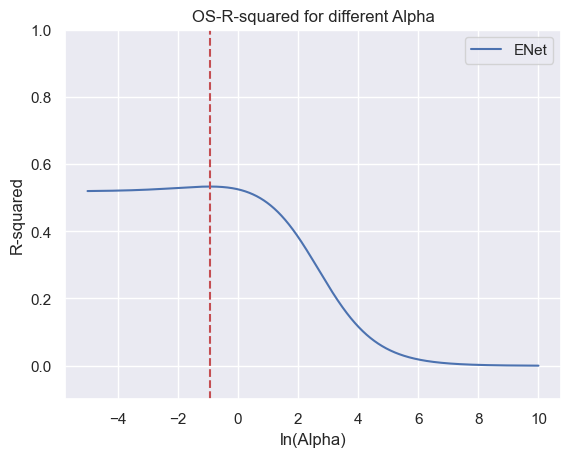

Optimal alpha for ENet=0.3933351194088322, best OS R_2=0.5330220187889485


In [168]:
#Elastic Net for 2019
# best Alpha
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(3,X19_train,y19_train,X19_valid,y19_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for ENet={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

The IS R-squared of Enet is: 0.46259899560005313
The OS R-squared of Enet is: 0.4517511404029798


<AxesSubplot:ylabel='Columns'>

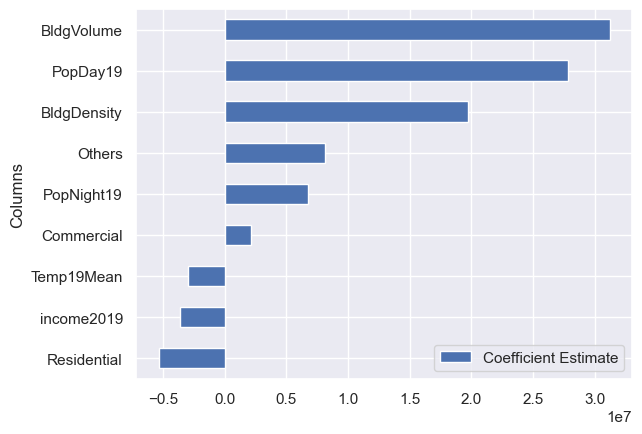

In [169]:
#ELASTIC NET 2019
# Train the model

e_net19=linear_model.ElasticNet(fit_intercept=False, alpha=alpha_optimal)

e_net19.fit(X19_train, y19_train)

# In sample:
y_pred_elastic_IS_e_net19 = e_net19.predict(X19_train)
print("The IS R-squared of Enet is: {0}".format(r2_score(y19_train,y_pred_elastic_IS_e_net19)))


#Out of sample
y_pred_elastic_OS_e_net19=e_net19.predict(X19_test)
print("The OS R-squared of Enet is: {0}".format(r2_score(y19_test,y_pred_elastic_OS_e_net19)))
e_net19.coef_



e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = X19_train.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net19.coef_)
e_net_coeff=e_net_coeff.sort_values(by='Coefficient Estimate',ascending=True)
e_net_coeff.plot.barh(x="Columns",y='Coefficient Estimate')



c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+18, tolerance: 9.456e+14

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+18, tolerance: 9.456e+14

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+18, tolerance: 9.456e+14

c:\ProgramData\Miniconda3

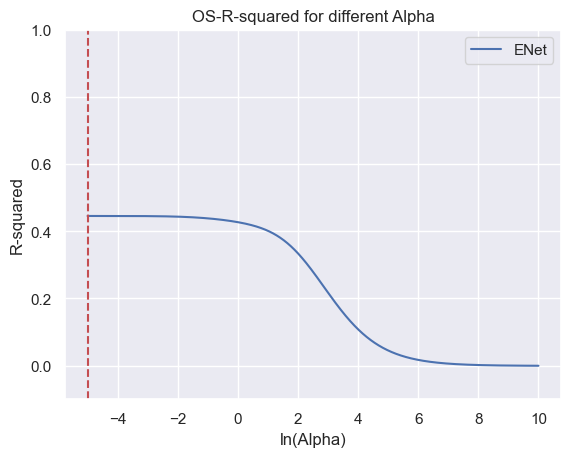

Optimal alpha for ENet=0.006737946999085467, best OS R_2=0.44549213802301735


In [170]:
#Elastic Net for 2020
# best Alpha
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(3,X20_train,y20_train,X20_valid,y20_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for ENet={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

The IS R-squared of Enet is: 0.3958212522646184
The OS R-squared of Enet is: 0.36908397896066314


c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e+18, tolerance: 1.140e+15



<AxesSubplot:ylabel='Columns'>

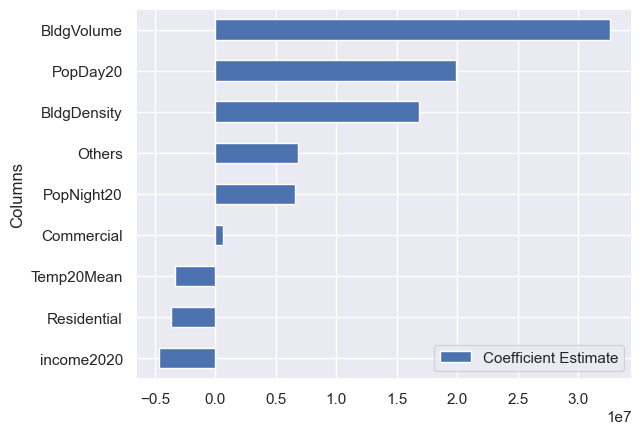

In [171]:
#ELASTIC NET 2020
# Train the model

e_net20=linear_model.ElasticNet(fit_intercept=False, alpha=alpha_optimal)

e_net20.fit(X20_train, y20_train)

# In sample:
y_pred_elastic_IS_e_net20 = e_net20.predict(X20_train)
print("The IS R-squared of Enet is: {0}".format(r2_score(y20_train,y_pred_elastic_IS_e_net20)))


#Out of sample
y_pred_elastic_OS_e_net20=e_net20.predict(X20_test)
print("The OS R-squared of Enet is: {0}".format(r2_score(y20_test,y_pred_elastic_OS_e_net20)))
e_net20.coef_



e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = X20_train.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net20.coef_)
e_net_coeff=e_net_coeff.sort_values(by='Coefficient Estimate',ascending=True)
e_net_coeff.plot.barh(x="Columns",y='Coefficient Estimate')



In [172]:
# #RUN PERMUTATION of STRONGEST TO WEAKEST REGRESSORS Report R2 each time. see how R2 will get lower each time
# #Elastic Net for 2020
# # best Alpha
# X20_train_permutationColumns=[]
# X20_valid_permutationColumns=[]
# bestAlphas=[]
# bestR2=[]
# ISR2=[]
# for i in X20_train.columns:
#     X20_train_permutationColumns.append(i)
#     X20_valid_permutationColumns.append(i)
#     # print(X20_train_permutationColumns)

#     X20_train_permutation=X20_train[np.intersect1d(X20_train.columns, X20_train_permutationColumns)]
#     X20_valid_permutation=X20_valid[np.intersect1d(X20_valid.columns, X20_valid_permutationColumns)]


#     alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
#     [alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(3,X20_train_permutation,y20_train,X20_valid_permutation,y20_valid,alphas,Graph=False,logl=True)
#     print('Optimal alpha for ENet={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#     bestAlphas.append(alpha_optimal)
#     bestR2.append(best_R2)

# #ELASTIC NET 2020 
# # Train the model
#     e_net20=linear_model.ElasticNet(fit_intercept=False, alpha=alpha_optimal)

#     e_net20.fit(X20_train_permutation, y20_train)

#     # In sample:
#     y_pred_elastic_IS_e_net20 = e_net20.predict(X20_train_permutation)
#     print("The IS R-squared of Enet is: {0}".format(r2_score(y20_train,y_pred_elastic_IS_e_net20)))
#     r2=r2_score(y20_train,y_pred_elastic_IS_e_net20)
#     print(r2)
#     ISR2.append(r2)




In [173]:
# #plot ISR2
# pd.DataFrame(ISR2).plot.bar()

In [174]:
CensusTracts2020

,BldgVolume,BldgDensity,Commercial,Others,Residential,income2020,PopDay20,PopNight20,Temp20Mean,EnergyUse_kWh20
0,1.936552e+06,21.438,0.170732,0.121951,0.707317,30435.0,2433.0,2610.0,23.119423,2289739.5
1,7.281368e+06,30.346,0.128049,0.207317,0.664634,17398.0,5940.0,9512.0,21.827769,85416384.0
2,1.876775e+06,20.078,0.181818,0.454545,0.363636,97875.0,2194.0,3220.0,22.692742,74805920.0
3,7.376846e+06,33.095,0.274194,0.119355,0.606452,51480.0,9595.0,5822.0,22.650927,43620188.0
4,2.722903e+07,114.485,0.308571,0.400000,0.291429,250001.0,35794.0,5988.0,21.451571,243436336.0
...,...,...,...,...,...,...,...,...,...,...
1588,2.445850e+06,13.108,0.048583,0.052632,0.898785,77191.0,799.0,2223.0,23.894251,8601279.0
1589,5.388328e+06,29.536,0.307692,0.092308,0.600000,94345.0,4605.0,7535.0,22.562904,88827320.0
1591,2.902529e+06,16.118,0.224265,0.040441,0.735294,77667.0,1884.0,4193.0,22.730232,44023848.0
1592,1.181982e+06,11.589,0.122222,0.022222,0.855556,80250.0,1840.0,1123.0,23.805078,17181810.0
